In [2]:
import os
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

In [3]:
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0,rpath)
from src.plots import Plot

In [4]:
df = pd.read_csv('../data/cleaned_data_outliers.csv')

In [5]:
df.head(5)
column_name = 'msisdn/number'
value_to_match = 33663706799.0
mask = df[column_name] == value_to_match
df = df[~mask]

In [6]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


In [7]:
df["social_media"] = df["social_media_dl_(bytes)"] + df['social_media_ul_(bytes)']
df["google"] = df["google_dl_(bytes)"] + df["google_ul_(bytes)"]
df['email'] = df["email_dl_(bytes)"] + df["email_ul_(bytes)"]
df['youtube'] = df["youtube_dl_(bytes)"] + df["youtube_ul_(bytes)"]
df['netflix'] = df["netflix_dl_(bytes)"] + df["netflix_ul_(bytes)"]
df["gaming"] = df["gaming_dl_(bytes)"] + df["gaming_ul_(bytes)"]
df['other'] = df["other_dl_(bytes)"]+df["other_ul_(bytes)"]
df['total_data'] = df['total_dl_(bytes)'] + df['total_ul_(bytes)']

In [8]:
df = df.rename( columns={'bearer_id': 'sessions'})

In [9]:
data_aggregate = df.groupby('msisdn/number').agg({'sessions': 'count', 'dur._(ms)': 'sum', 'total_data': 'sum'})

In [10]:
data_aggregate.head()


,sessions,dur._(ms),total_data
msisdn/number,,,
3.360100e+10,1,11.667533,37.952551
3.360100e+10,1,12.107522,36.011203
3.360100e+10,1,11.812800,37.624373
3.360101e+10,1,10.817335,36.639432
3.360101e+10,2,19.656666,75.943057


In [11]:
sessions = data_aggregate.nlargest(10, "sessions")['sessions']
duration = data_aggregate.nlargest(10, "dur._(ms)")['dur._(ms)']
total_data = data_aggregate.nlargest(10, "total_data")['total_data']

In [12]:
sesssions_df = pd.DataFrame()
sesssions_df['User_ID'] = sessions.index
sesssions_df['Sessions'] = sessions.values
durations_df = pd.DataFrame()
durations_df['User_ID'] = duration.index
durations_df['duration'] = duration.values
total_data_df = pd.DataFrame()
total_data_df['User_ID'] = total_data.index
total_data_df['total_data'] = total_data.values

In [13]:
durations_df.head()

,User_ID,duration
0,3.362578e+10,233.413129
1,3.362632e+10,231.977427
2,3.361489e+10,222.446521
3,3.365973e+10,198.016024
4,3.376054e+10,195.767900


Aggregate per-customer id and report top 10 engagement 

[]

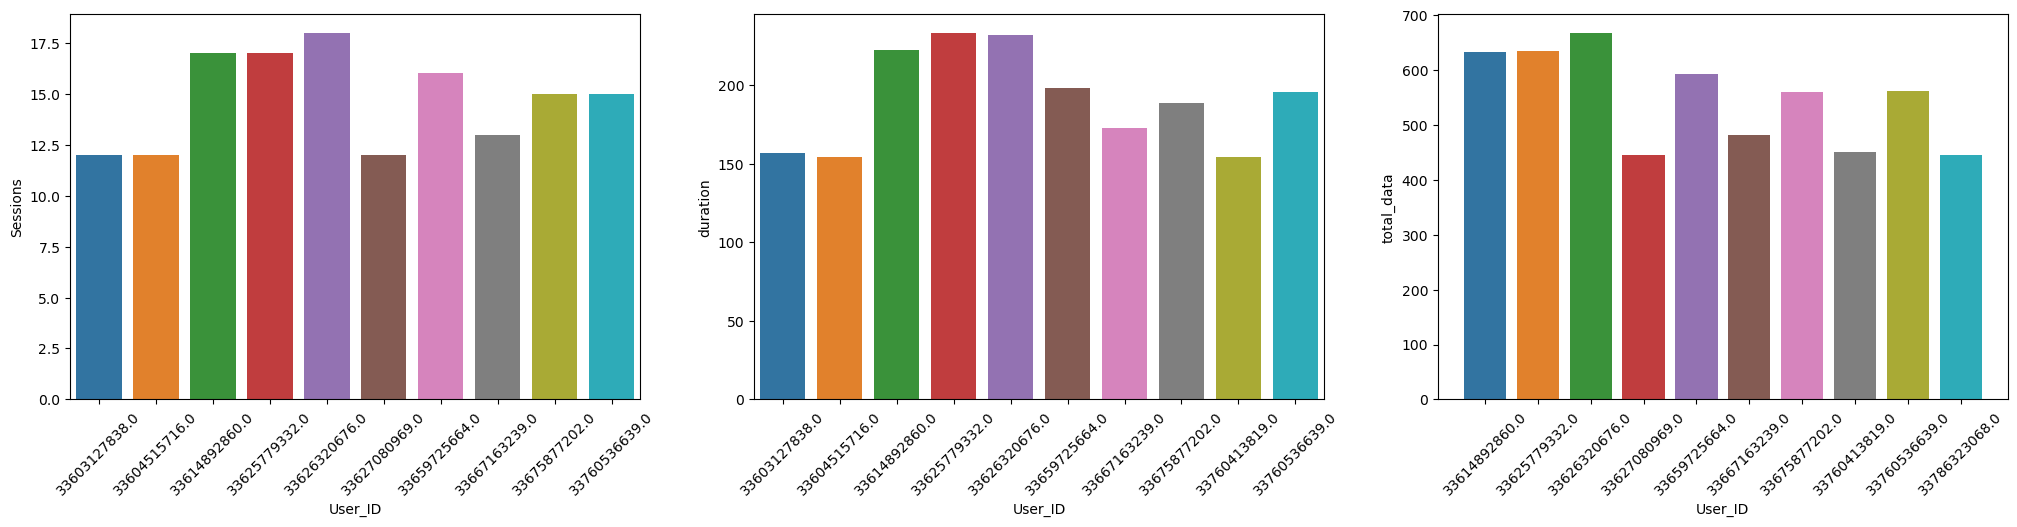

In [14]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=sesssions_df, x='User_ID', orient='v', y='Sessions', ax=axes[0])
ax2 = sns.barplot(data=durations_df, x='User_ID',orient='v', y='duration', ax=axes[1])
ax3 = sns.barplot(data=total_data_df, x='User_ID',orient='v', y='total_data', ax=axes[2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


Normalize each metric

In [15]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

In [16]:
normalizer = Normalizer()

Run K Means Cluster for classification

In [17]:
columns = ['sessions','dur._(ms)','total_data']
selected_columns = data_aggregate[columns]
normalized_data = normalizer.fit_transform(selected_columns)

In [18]:
normalized_user_data = pd.DataFrame(normalized_data, columns=columns)
normalized_user_data.head(5)

,sessions,dur._(ms),total_data
0,0.025177,0.293759,0.955548
1,0.026312,0.318575,0.947532
2,0.025350,0.299453,0.953774
3,0.026167,0.283058,0.958746
4,0.025487,0.250495,0.967782


In [19]:
normalized_user_data.describe()

,sessions,dur._(ms),total_data
count,106855.000000,106855.000000,106855.000000
mean,0.025714,0.290363,0.956384
std,0.000504,0.018112,0.005407
min,0.024454,0.226974,0.930108
25%,0.025351,0.281301,0.952876
50%,0.025624,0.292597,0.955891
75%,0.025979,0.302272,0.959275
max,0.028807,0.366379,0.973566


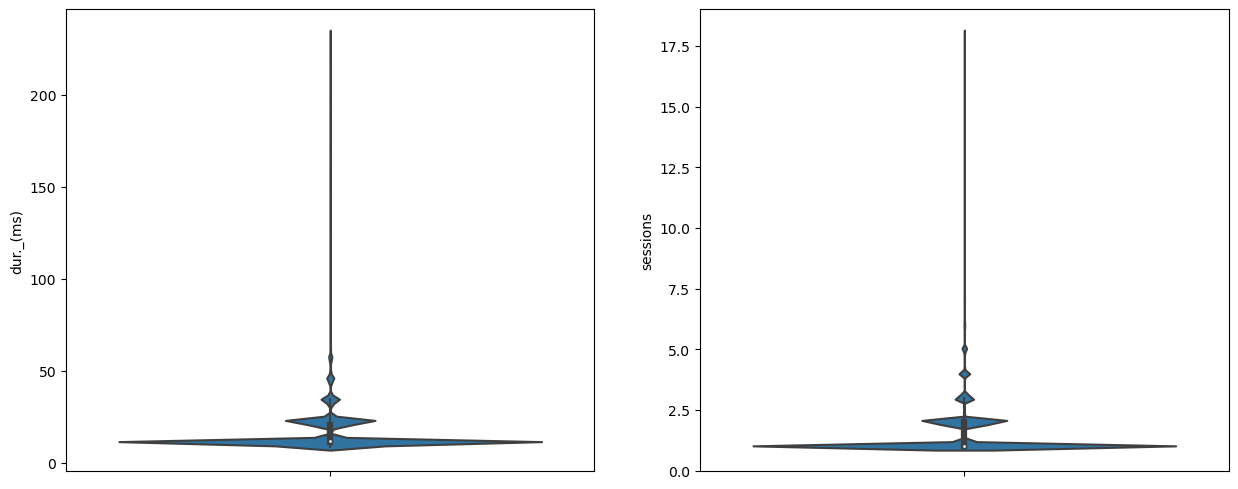

In [20]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(y=data_aggregate["dur._(ms)"])
# sns.boxplot(y=user_engagement["dur._(ms)"], color="red")
plt.subplot(1,2,2)
sns.violinplot(y=data_aggregate["sessions"])
# sns.boxplot(y=user_engagement["total_data"])
plt.show()


In [21]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_user_data)
centroids = kmeans.cluster_centers_

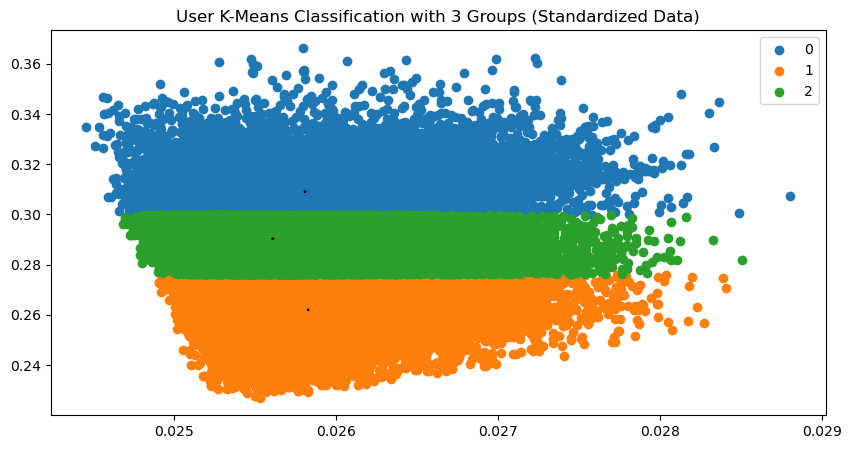

In [22]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_user_data[label == i].iloc[:,0] , normalized_user_data[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [23]:
normalized_user_data.head()

,sessions,dur._(ms),total_data
0,0.025177,0.293759,0.955548
1,0.026312,0.318575,0.947532
2,0.025350,0.299453,0.953774
3,0.026167,0.283058,0.958746
4,0.025487,0.250495,0.967782


In [24]:
clustered_Df = pd.DataFrame()
clustered_Df['data_index'] = normalized_user_data.index.values
clustered_Df['cluster'] = kmeans.labels_

In [25]:
clustered_Df.cluster.value_counts()

cluster
2    52022
0    33199
1    21634
Name: count, dtype: int64

In [26]:
u_eng = data_aggregate.copy()

In [27]:
u_eng.insert(0, 'cluster', kmeans.labels_)
u_eng.head(5)

,cluster,sessions,dur._(ms),total_data
msisdn/number,,,,
3.360100e+10,2,1,11.667533,37.952551
3.360100e+10,0,1,12.107522,36.011203
3.360100e+10,2,1,11.812800,37.624373
3.360101e+10,2,1,10.817335,36.639432
3.360101e+10,1,2,19.656666,75.943057


In [28]:
cluster1 = u_eng[u_eng["cluster"]==0]
cluster1.describe()

,cluster,sessions,dur._(ms),total_data
count,33199.0,33199.000000,33199.000000,33199.000000
mean,0.0,1.346516,16.149738,49.682595
std,0.0,0.856955,10.520387,31.869365
min,0.0,1.000000,10.555057,33.019835
25%,0.0,1.000000,11.849087,36.428168
50%,0.0,1.000000,12.059919,37.328590
75%,0.0,1.000000,12.740560,38.140283
max,0.0,18.000000,233.413129,667.707948


In [29]:
cluster2 = u_eng[u_eng["cluster"] == 1]
cluster2.describe()

,cluster,sessions,dur._(ms),total_data
count,21634.0,21634.000000,21634.000000,21634.000000
mean,1.0,1.249700,12.710678,46.686258
std,0.0,0.490897,5.152292,18.335335
min,1.0,1.000000,8.873748,33.855789
25%,1.0,1.000000,9.923400,37.186444
50%,1.0,1.000000,10.326612,37.748337
75%,1.0,1.000000,10.823307,38.334768
max,1.0,7.000000,74.685922,263.095992


In [30]:
cluster3 = u_eng[u_eng["cluster"] == 2]
cluster3.describe()

,cluster,sessions,dur._(ms),total_data
count,52022.0,52022.000000,52022.000000,52022.000000
mean,2.0,1.483891,16.814749,55.394130
std,0.0,0.864540,9.795258,32.143086
min,2.0,1.000000,9.891617,33.644288
25%,2.0,1.000000,11.366731,37.309876
50%,2.0,1.000000,11.488289,37.892481
75%,2.0,2.000000,22.432023,74.171742
max,2.0,11.000000,119.708476,404.881781


In [31]:
cluster3.sessions.count()

52022

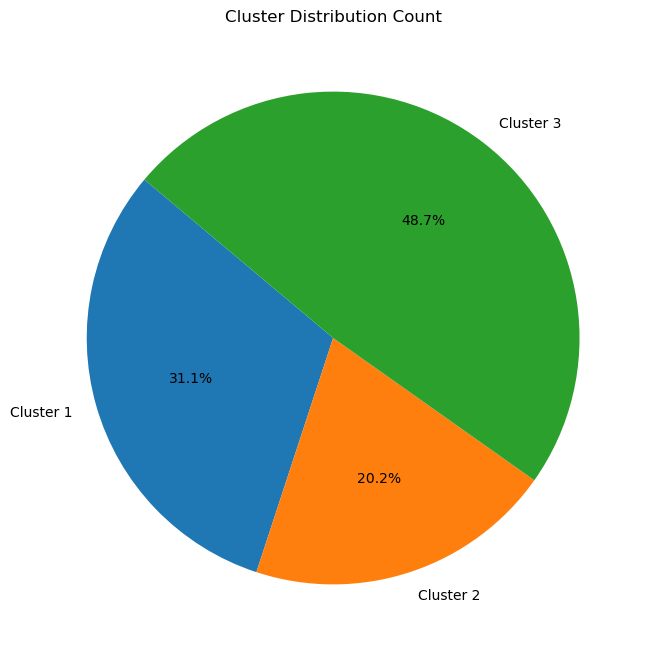

In [32]:
data = [cluster1.sessions.count(), cluster2.sessions.count(), cluster3.sessions.count()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
plot = Plot()
plot.plot_pie(data=data, label=keys, title="Cluster Distribution Count")

In [33]:
user_app_usage = df.groupby(
    'msisdn/number').agg({ 'social_media': 'sum', 'gaming': 'sum', 'youtube': 'sum', 'netflix': 'sum', 'google': 'sum', 'email': 'sum', 'other': 'sum'})

In [34]:
# Drop an outlier
user_app_usage.reset_index(inplace=True)
# Drop the 'msisdn/number' column
user_app_usage = user_app_usage.drop('msisdn/number', axis=1)


In [35]:
user_app_usage

,social_media,gaming,youtube,netflix,google,email,other
0,24.758478,34.642406,32.238131,32.788024,28.886711,26.748271,35.812062
1,25.805627,34.974170,31.264510,29.717111,29.194096,27.934743,34.030799
2,25.733266,36.180352,31.345269,31.475514,26.531873,28.258763,35.723909
3,22.704073,34.707784,30.060477,27.534749,30.731634,26.165886,33.165518
4,48.636766,70.313658,63.649461,64.349061,60.823188,53.460940,71.318676
...,...,...,...,...,...,...,...
106850,23.459775,35.229296,32.656413,28.410670,29.192118,26.256508,34.664492
106851,23.938975,35.928164,32.010315,30.037566,29.393481,21.235442,34.820827
106852,24.162892,35.335906,30.668889,32.755307,30.403346,27.071495,34.825549
106853,23.250760,36.032357,33.443815,32.972744,30.216433,27.614238,34.179043


In [36]:
social_media = user_app_usage.nlargest(10, "social_media")['social_media']
gaming = user_app_usage.nlargest(10, "gaming")['gaming']
youtube = user_app_usage.nlargest(10, "youtube")['youtube']
netflix = user_app_usage.nlargest(10, "netflix")['netflix']
google = user_app_usage.nlargest(10, "google")['google']
email = user_app_usage.nlargest(10, "email")['email']
other = user_app_usage.nlargest(10, "other")['other']


In [37]:
social_media_df = pd.DataFrame()
social_media_df['User_ID'] = social_media.index
social_media_df['social_media'] = social_media.values
gaming_df = pd.DataFrame()
gaming_df['User_ID'] = gaming.index
gaming_df['gaming'] = gaming.values
youtube_df = pd.DataFrame()
youtube_df['User_ID'] = youtube.index
youtube_df['youtube'] = youtube.values

netflix_df = pd.DataFrame()
netflix_df['User_ID'] = netflix.index
netflix_df['netflix'] = netflix.values
google_df = pd.DataFrame()
google_df['User_ID'] = google.index
google_df['google'] = google.values
email_df = pd.DataFrame()
email_df['User_ID'] = email.index
email_df['email'] = email.values
others_df = pd.DataFrame()
others_df['User_ID'] = other.index
others_df['other'] = other.values

[]

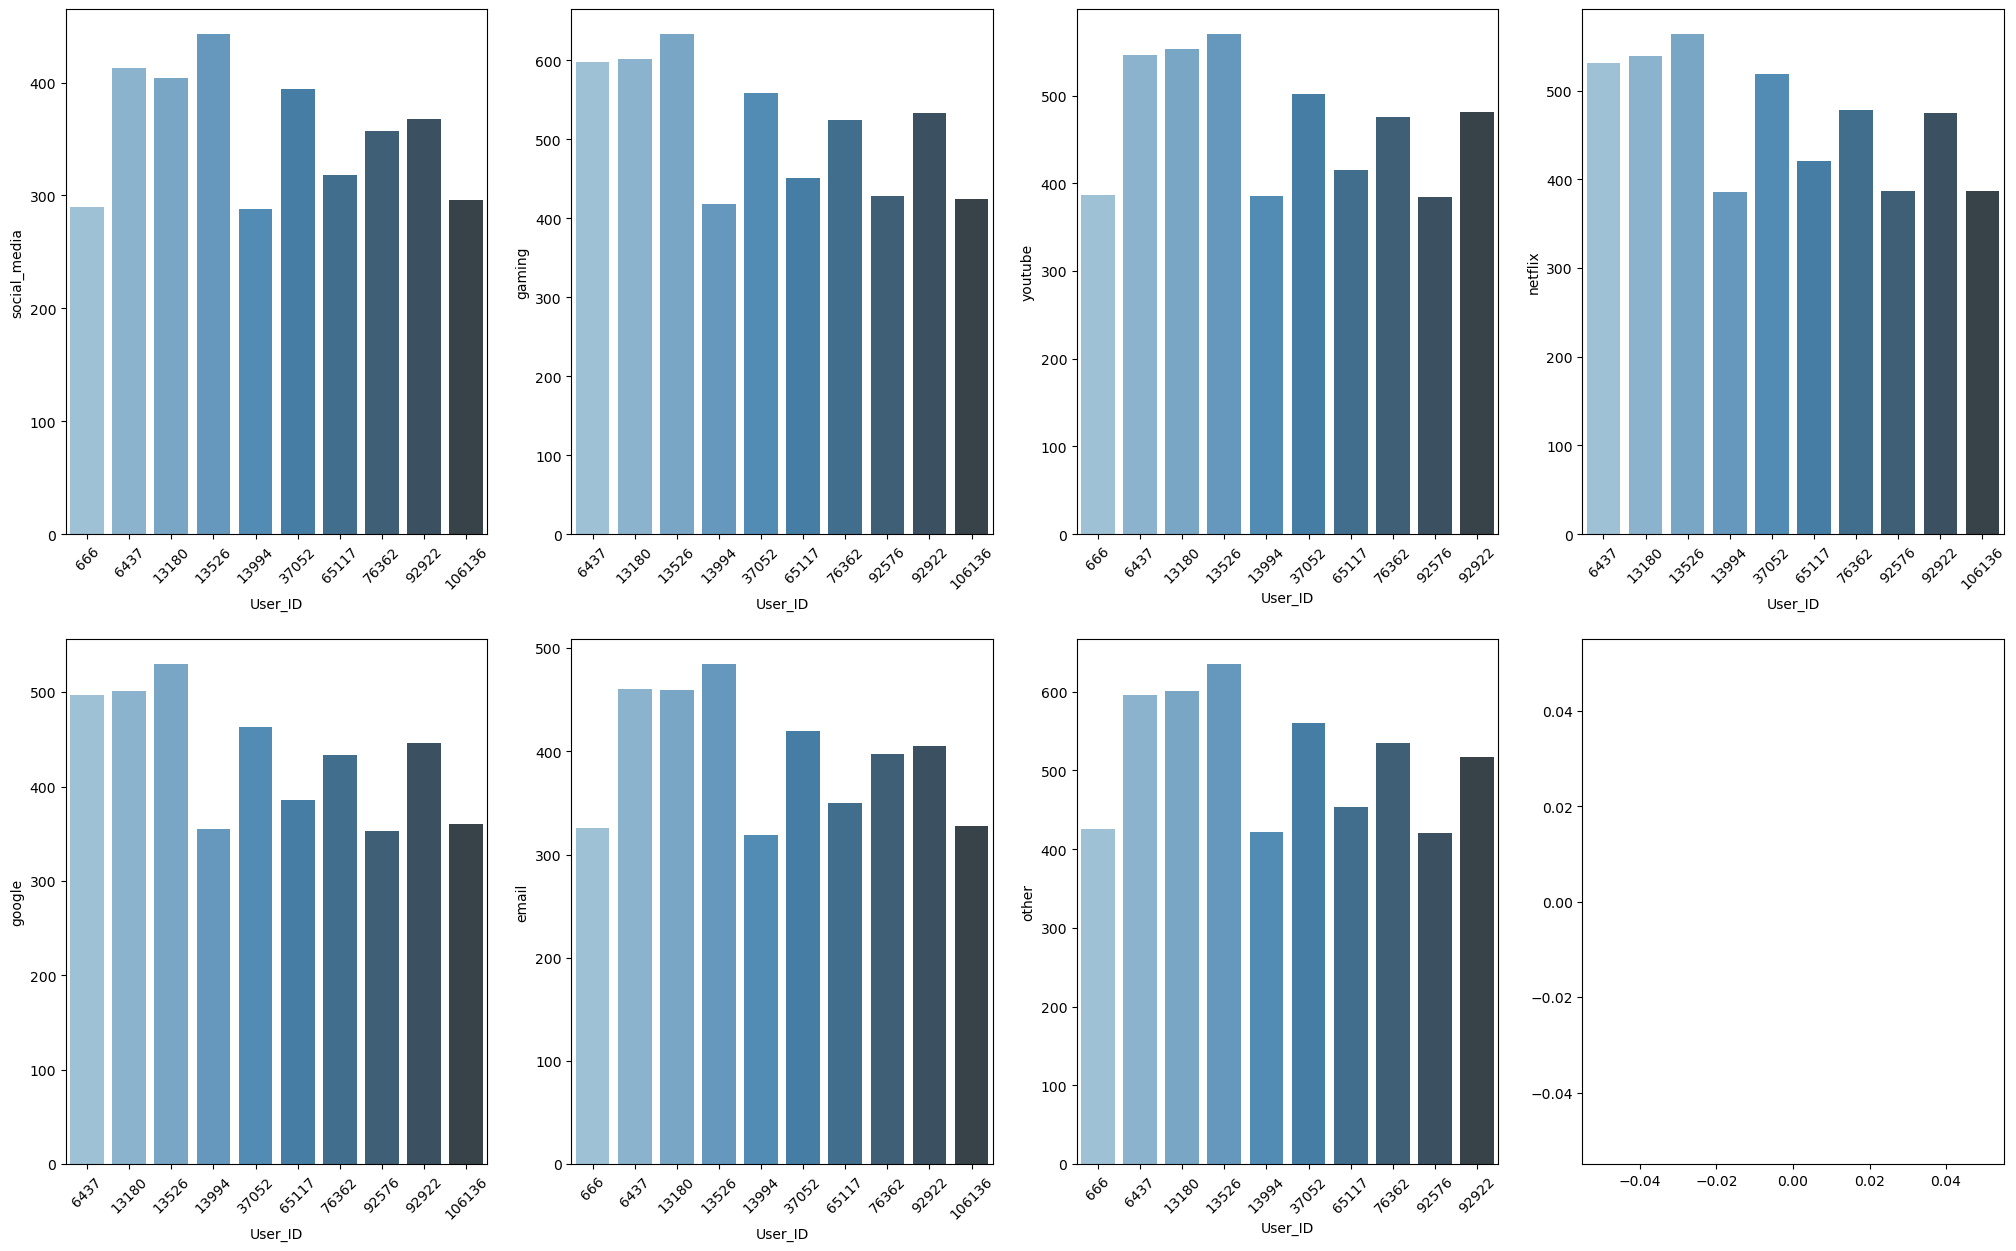

In [38]:
f, axes = plt.subplots(2, 4, figsize=(25, 15))
ax1 = sns.barplot(data=social_media_df, x='User_ID', orient='v', y='social_media', ax=axes[0,0], palette='Blues_d')
ax2 = sns.barplot(data=gaming_df, x='User_ID',orient='v', y='gaming', ax=axes[0,1], palette='Blues_d')
ax3 = sns.barplot(data=youtube_df, x='User_ID',orient='v', y='youtube', ax=axes[0,2], palette='Blues_d')
ax4 = sns.barplot(data=netflix_df, x='User_ID',orient='v', y='netflix', ax=axes[0,3], palette='Blues_d')
ax5 = sns.barplot(data=google_df, x='User_ID',orient='v', y='google', ax=axes[1,0], palette='Blues_d')
ax6 = sns.barplot(data=email_df, x='User_ID',orient='v', y='email', ax=axes[1,1], palette='Blues_d')
ax7 = sns.barplot(data=others_df, x='User_ID',orient='v', y='other', ax=axes[1,2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
ax4.set_xticklabels(ax4.xaxis.get_majorticklabels(), rotation=45)
ax5.set_xticklabels(ax5.xaxis.get_majorticklabels(), rotation=45)
ax6.set_xticklabels(ax6.xaxis.get_majorticklabels(), rotation=45)
ax7.set_xticklabels(ax7.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


In [39]:
top_used_applications = user_app_usage.sum()

In [40]:
top_used_applications.values

array([            -inf, 5238909.02604377, 4746610.02948139,
       4745967.86728169, 4391648.22869947, 3997218.6894615 ,
       5237872.25900656])

In [41]:
top_3_used = top_used_applications.nlargest(3)

In [42]:
top_3_used

gaming     5.238909e+06
other      5.237872e+06
youtube    4.746610e+06
dtype: float64

/opt/homebrew/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


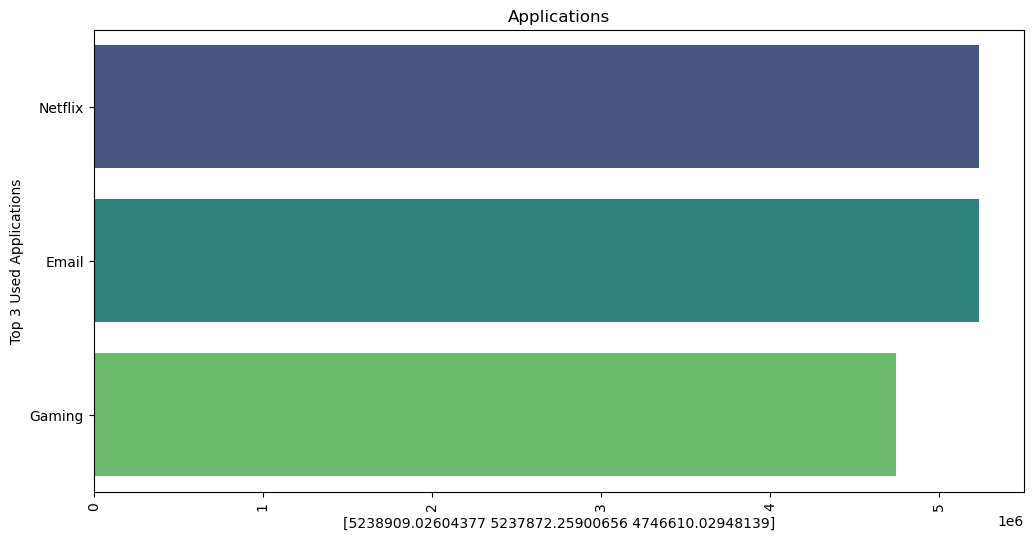

In [43]:
plot.plot_bar(top_3_used, ["Netflix", "Email", "Gaming"], top_3_used.values, "Top 3 Used Applications", "Applications", "Usage Count")

In [44]:
inertias = []
for i in range(1,16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(normalized_user_data)
    inertias.append(kmeans.inertia_)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

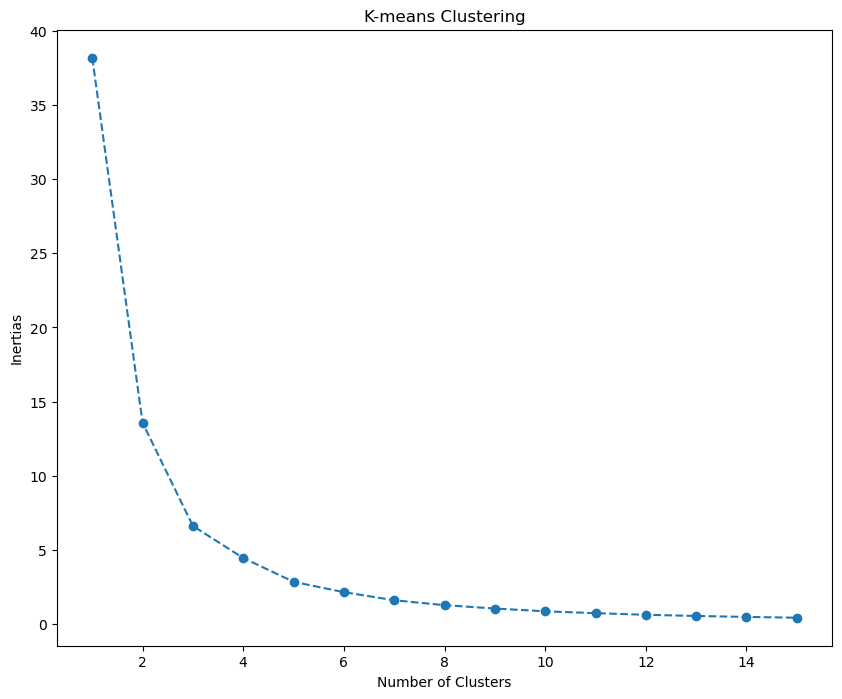

In [45]:
# Plotting the cluster size vs. inertia graph to find the optimal cluster
plt.figure(figsize = (10,8))
plt.plot(range(1, 16), inertias, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('K-means Clustering')
plt.show()

In [46]:
kl = KneeLocator(range(0, 15), inertias, curve="convex", direction="decreasing")
kl.elbow

2

In [47]:
u_eng.shape

(106855, 4)

In [48]:
u_eng.to_csv('../data/user_eng.csv')

In [49]:
user_app_usage.to_csv('../data/normalized_eng.csv')

In [50]:
import joblib
joblib.dump(kmeans,'../models/user_engagement.pkl')

['../models/user_engagement.pkl']